In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import glob
import re

In [ ]:
"""
Noise
"""

main_directory = r"D:\TAU\Final_Project\final mes"

# Initialize a dictionary to store results
Noise = {}

# Get the list of subfolders in the main directory
subfolders = [f.path for f in os.scandir(main_directory) if f.is_dir()]

# Process each subfolder (parameter value)
for subfolder in subfolders:
    # Extract the parameter value from the subfolder name
    param_value = os.path.basename(subfolder)
    if param_value == 'noise':
        # Initialize lists to store results for this subfolder
        angles1 = []
        data_avgs1 = []
        data_stds1 = []

        # Get the list of files in the current subfolder
        files = glob.glob(os.path.join(subfolder, '*'))

        # Process each file in the subfolder
        for file_path in files:
            file_name = os.path.basename(file_path)

            with open(file_path, "r") as f:
                df = pd.read_csv(f, sep='\t')

                parts = file_name.split(',')
                angle_loc = [i for i, part in enumerate(parts) if 'angle' in part]
                if angle_loc:
                    angle = float(parts[angle_loc[0]].split('=')[1])
                    angles1.append(angle)

                data_avg = np.mean(np.array(df.iloc[:, 1]))
                data_std = np.std(np.array(df.iloc[:, 1])) / np.sqrt(len(np.array(df.iloc[:, 1])))

                data_avgs1.append(data_avg)
                data_stds1.append(data_std)

        # Store results in the dictionary with the parameter value as the key
        Noise[param_value] = list(zip(data_avgs1, data_stds1, angles1))
        noise_avg , noise_std = np.mean(Noise['noise'][0][0],Noise['noise'][1][0]),
        np.sqrt((Noise['noise'][0][1]**2 + Noise['noise'][1][1]**2)* 1e-12 )

In [4]:
"""
Data after getting rid of noise
"""

# Set the main directory containing subfolders
main_directory = r"D:\TAU\Final_Project\final mes"

# Initialize a dictionary to store results
results = {}

# Get the list of subfolders in the main directory
subfolders = [f.path for f in os.scandir(main_directory) if f.is_dir()]

# Process each subfolder (parameter value)
for subfolder in subfolders:
    # Extract the parameter value from the subfolder name
    param_value = os.path.basename(subfolder)
    
    if param_value != 'noise':
    
        # Initialize lists to store results for this subfolder
        angles1 = []
        data_avgs1 = []
        data_stds1 = []

        # Get the list of files in the current subfolder
        files = glob.glob(os.path.join(subfolder, '*'))

        # Process each file in the subfolder
        for file_path in files:
            file_name = os.path.basename(file_path)

            with open(file_path, "r") as f:
                df = pd.read_csv(f, sep='\t')

                parts = file_name.split(',')
                angle_loc = [i for i, part in enumerate(parts) if 'angle' in part]
                if angle_loc:
                    angle = float(parts[angle_loc[0]].split('=')[1])
                    angles1.append(angle)

                data_avg = np.mean(np.array(df.iloc[:, 1])) - noise_avg
                data_std = np.std(np.array(df.iloc[:, 1])) / np.sqrt(len(np.array(df.iloc[:, 1])))

                data_avgs1.append(data_avg)
                data_stds1.append(np.sqrt(data_std**2 + noise_std**2))

        # Store results in the dictionary with the parameter value as the key
        results[param_value] = list(zip(data_avgs1, data_stds1, angles1))

    # Now `results` dictionary contains the desired data structure


In [9]:
"""
Fitting Data
"""

from scipy.optimize import curve_fit

def func(x, A, B, C, D):
    y= A*(np.cos((2*np.pi/180)*B*(x-C))**2)+ D
    return y
  
    
fit = {}

    
for folder in results.keys():    
    
    data = np.array([list(i) for i in results[folder]]).T
    angles = data[2,:][np.argsort(data[2,:])]
    values = data[0,:][np.argsort(data[2,:])]
    error = data[1,:][np.argsort(data[2,:])]
    
    for i,val in enumerate(values):
        if val < 0:
            np.delete(values,i)
            np.delete(angles,i)
            np.delete(error,i)
    
    parameters, covariance = curve_fit(func, angles, values
    ,p0=[10e-4,0.45,50,15e-5]
    ,sigma = error                            
    )
    
    fit[folder] = [parameters, covariance]
    

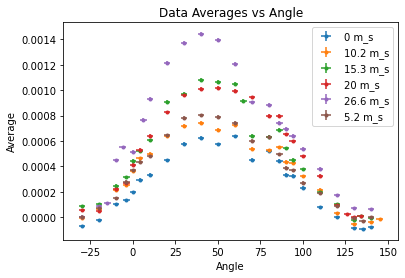

In [15]:
"""
The Data's Graph
"""

for j,folder in enumerate([i for i in results.keys() if  i != '10.2 m_s - no fan']):    
    
    data = np.array([list(i) for i in results[folder]]).T
    angles = data[2,:][np.argsort(data[2,:])]
    values = data[0,:][np.argsort(data[2,:])]
    error = data[1,:][np.argsort(data[2,:])]

    for i,val in enumerate(values):
        if val < 0:
            np.delete(values,i)
            np.delete(angles,i)
            np.delete(error,i)

    plt.errorbar(np.array(angles), np.array(values),
                 np.array(error),2*np.ones(len(angles)),'.', label=f"{folder}")
plt.xlabel('Angle')
plt.ylabel('Average')
plt.title('Data Averages vs Angle')
plt.legend()
plt.show()

0 m_s [-7.18e-05 -2.32e-05 -8.61e-05 -9.16e-05 -7.64e-05]
5.2 m_s [-2.90e-06 -2.78e-05 -1.40e-06]
10.2 m_s [-4.40e-06 -5.46e-05 -3.77e-05 -1.34e-05]
15.3 m_s [-2.47e-05 -4.10e-06]
20 m_s []
26.6 m_s []


<Figure size 432x288 with 0 Axes>

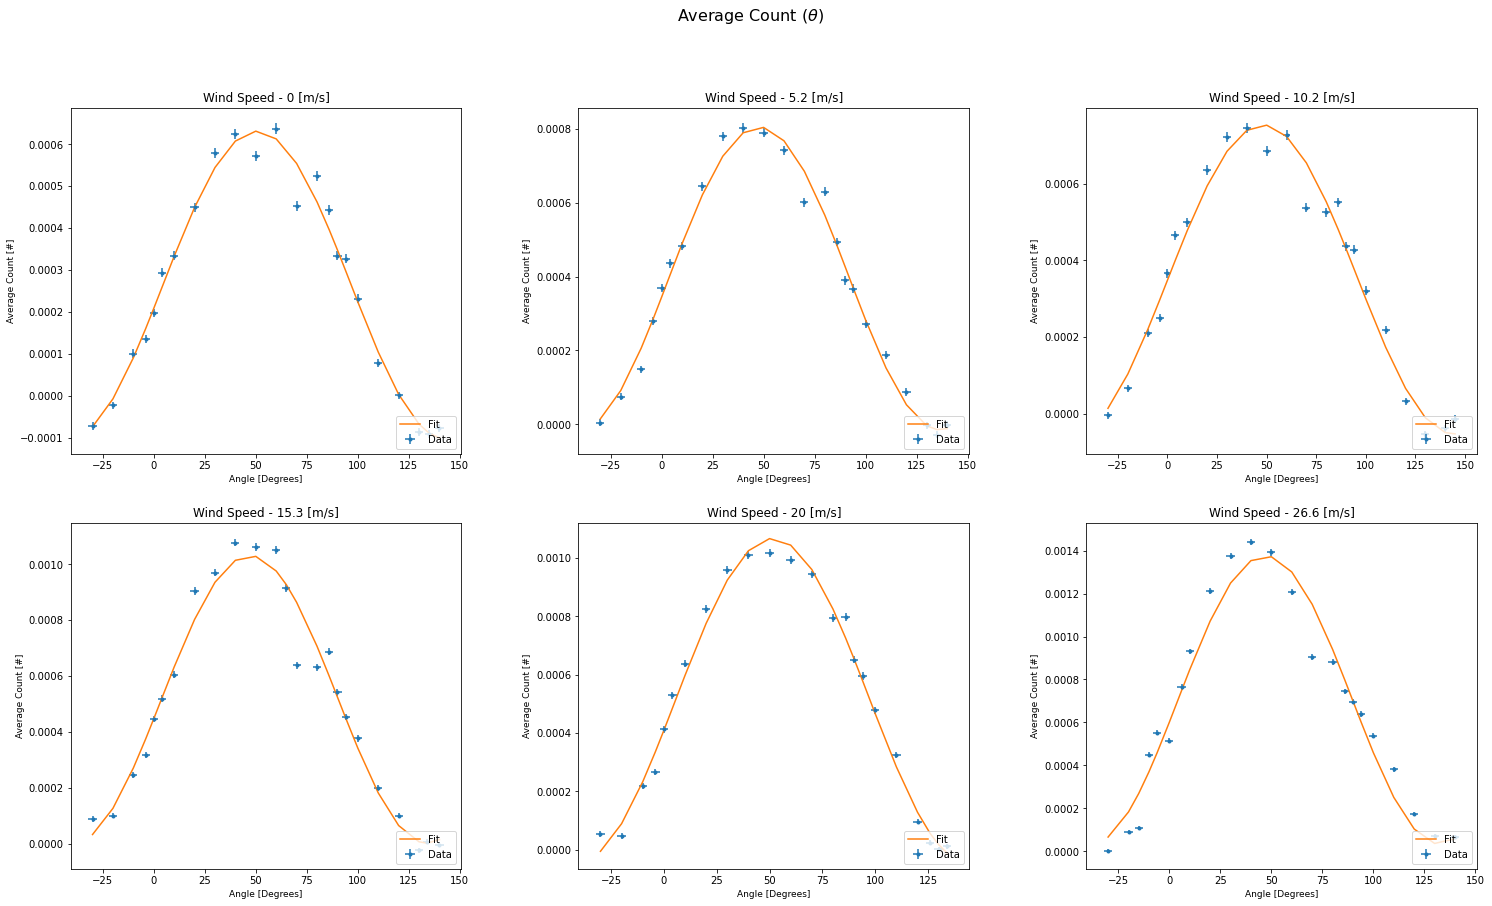

In [32]:
"""
Fit Graphs
"""


original_size = plt.gcf().get_size_inches()
# Adjust the size to fit 6 plots in a 2x3 grid
new_size = (original_size[0] * 4.2, original_size[1] * 3.5)

# Create a figure with the adjusted size and a title
plt.figure(figsize=new_size).suptitle(r"Average Count ($\theta$)", fontsize=16)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.2, wspace=0.3)

# Ensure you're plotting only 6 plots in a 2x3 grid
def extract_float(s):
    return float(re.findall(r"[-+]?\d*\.\d+|\d+", s)[0])

# Filter out the folder you don't want and sort the rest
folders = sorted([i for i in results.keys() if i != '10.2 m_s - no fan'], key=extract_float)


for j, folder in enumerate(folders):
    data = np.array([list(i) for i in results[folder]]).T
    angles = data[2, :][np.argsort(data[2, :])]
    values = data[0, :][np.argsort(data[2, :])]
    error = data[1, :][np.argsort(data[2, :])]
    
    for i,val in enumerate(values):
        if val < 0:
            np.delete(values,i)
            np.delete(angles,i)
            np.delete(error,i)
    
    
    #filttered Values!
    print(folder, values[values<0])
    
    # Calculate the position in the 2x3 grid (3 columns, 2 rows)
    plt.subplot(2, 3, j + 1).set_title(f"Wind Speed - {folder.replace('m_s','[m/s]')}")

    plt.errorbar(np.array(angles), np.array(values),
                 np.array(error), 2 * np.ones(len(angles)), '.', color='tab:blue', label="Data")

    fitting = func(np.array(angles), fit[folder][0][0], fit[folder][0][1], fit[folder][0][2], fit[folder][0][3])

    plt.plot(np.array(angles), fitting, color='tab:orange', label="Fit")
    plt.legend(loc='lower right')

    #Axis titles
    plt.xlabel("Angle [Degrees]", fontsize=9)
    plt.ylabel("Average Count [#]", fontsize=9)
    
    
# Display the figure
plt.show()


In [13]:
"""
Info about the fit
"""


Vis = []
Max_teta = []
width = []

for key in folders:    
    # Extract data for the current folder
    data = np.array([list(i) for i in results[key]]).T
    angles = data[2, :][np.argsort(data[2, :])]
    values = data[0, :][np.argsort(data[2, :])]
    values[values<0] = np.abs(values[values<0]) 
    
    # Generate the fitting curve
    fitting = func(np.array(angles), fit[key][0][0], fit[key][0][1], fit[key][0][2], fit[key][0][3]) 
    
    # Calculate the visibility
    sorted_values = np.sort(values)
    fit_max_val = np.mean(sorted_values[-4:])  # Mean of the top 3 values
    fit_min_val = np.mean(sorted_values[:4])   # Mean of the bottom 4 values
    Visibillit = (fit_max_val - fit_min_val) / (fit_max_val + fit_min_val)
    
    # Append results to lists
    Vis.append(Visibillit)
    Max_teta.append(fit[key][0][2])
    width.append(fit[key][0][1])
    
    # Print results for the current folder
    print(f"{key}:")
    print(f"RMSE = {np.sqrt(np.mean((values - fitting)**2)):.4f}")
    print(f'Visibility = {Visibillit:.4f}')
    print(f'Max at Theta = {fit[key][0][2]:.2f}')
    print('\n\n')



0 m_s:
RMSE = 0.0001
Visibility = 0.8668
Max at Theta = 50.62



5.2 m_s:
RMSE = 0.0000
Visibility = 0.9771
Max at Theta = 47.84



10.2 m_s:
RMSE = 0.0001
Visibility = 0.9412
Max at Theta = 48.12



15.3 m_s:
RMSE = 0.0001
Visibility = 0.9420
Max at Theta = 47.09



20 m_s:
RMSE = 0.0000
Visibility = 0.9586
Max at Theta = 51.52



26.6 m_s:
RMSE = 0.0001
Visibility = 0.9195
Max at Theta = 47.01





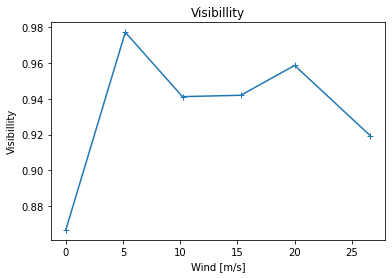

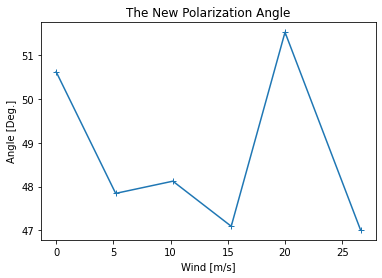

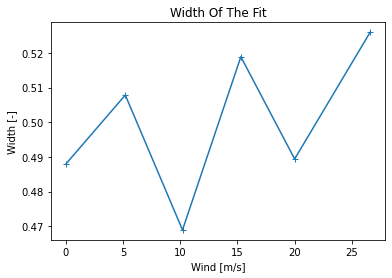

In [18]:
"""
fit info Comparison between the diffrent wind parameters 
"""


wind = [float(i.split(" ")[0]) for i in folders]

plt.title("Visibillity")
plt.plot(np.array(wind), np.array(Vis), marker = '+')
plt.xlabel('Wind [m/s]')
plt.ylabel('Visibillity')
plt.show()

plt.title("The New Polarization Angle")
plt.plot(np.array(wind), np.array(Max_teta),marker = '+')
plt.xlabel('Wind [m/s]')
plt.ylabel('Angle [Deg.]')
plt.show()

plt.title("Width Of The Fit")
plt.plot(np.array(wind), np.array(width),marker = '+')
plt.xlabel('Wind [m/s]')
plt.ylabel('Width [-]')
plt.show()

<Figure size 432x288 with 0 Axes>

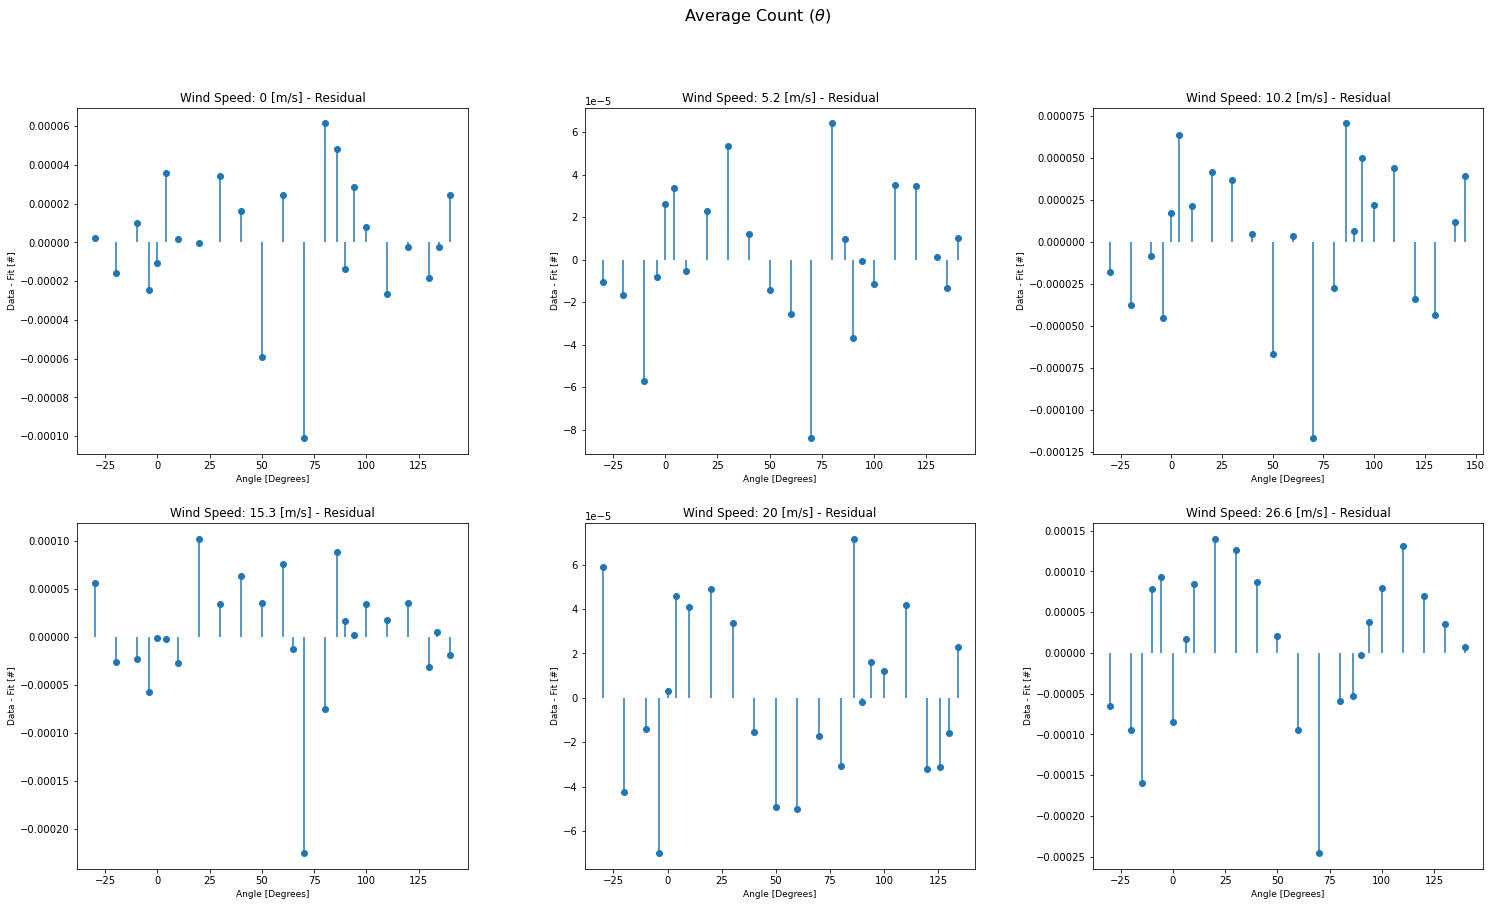

In [33]:
"""
Residuals Graphs
"""


import matplotlib.pyplot as plt
import numpy as np
import re

# Get the original figure size
original_size = plt.gcf().get_size_inches()
# Adjust the size to fit 6 plots in a 2x3 grid
new_size = (original_size[0] * 4.2, original_size[1] * 3.5)

# Create a figure with the adjusted size and a title
plt.figure(figsize=new_size).suptitle(r"Average Count ($\theta$)", fontsize=16)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.2, wspace=0.3)

# Function to extract floats from strings
def extract_float(s):
    return float(re.findall(r"[-+]?\d*\.\d+|\d+", s)[0])

# Filter out the folder you don't want and sort the rest
folders = sorted([i for i in results.keys() if i != '10.2 m_s - no fan'], key=extract_float)

# Iterate over folders and plot the data
for j, folder in enumerate(folders):
    data = np.array([list(i) for i in results[folder]]).T
    angles = data[2, :][np.argsort(data[2, :])]
    values = data[0, :][np.argsort(data[2, :])]
    error = data[1, :][np.argsort(data[2, :])]
    
    # Plot each folder in a subplot
    plt.subplot(2, 3, j + 1).set_title(f"Wind Speed: {folder.replace('m_s','[m/s]')} - Residual")

    # Calculate the fitting curve
    fitting = func(angles, fit[folder][0][0], fit[folder][0][1], fit[folder][0][2], fit[folder][0][3])
    
    # Plot sticks (vertical lines)
    plt.vlines(angles, ymin=0, ymax=values- fitting, color='tab:blue')

    # Plot the residuals using dots at the end of each stick
    plt.scatter(angles, values - fitting, color='tab:blue')

    #Axis titles
    plt.xlabel("Angle [Degrees]", fontsize=9)
    plt.ylabel("Data - Fit [#]", fontsize=9)
    
# Display the figure
plt.show()
